# Deep Learning with Python: Deep Learing from Text and Sequences

### Work-level one-hot encoding (toy example)

In [10]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

max_length = 10

results = np.zeros(shape=(len(samples),
                  max_length, 
                  max(token_index.values()) +1 ))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j, index] = 1

### Using Keras for word-level one-hot encoding

In [18]:
from keras.preprocessing.text import Tokenizer
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Creat a tokenizer that only includes the top 100 words
tokenizer = Tokenizer(num_words=100)
# Build the word index
tokenizer.fit_on_texts(samples)

# Turn stings into lists of integer indices
seuqences = tokenizer.texts_to_sequences(samples)

one_hit_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

Found 9 unique tokens.


### Word-Level One-Hot Encoding with hashing trick

In [ ]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_lenght = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerat(samples):
    fro j, word in list(enumerate(sample.split()))[:max_length]:
        # Hashes the word into a random integer index between 0 and 1,000
        index = abs(hash(word)) % dimensionality
        results[i, j, index]  = 1

### Instantiating and Embedding Layer

In [20]:
from keras.layers import Embedding
embedding_layer = Embedding(1000,4)

### Loading the IMDB dat afor use with an Embedding Layer

In [22]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000 #Number of words to consider as features
# Cuts off the text after this number of words 
# (among the max_features most common words)
maxlen = 20 

# Load the data as a lists of intergers
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)

# Turns the lists of integers into a 2D integer tensor of shapes
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### Ues an Embedding layer and classifier on the IMDB data

In [28]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

# model = Sequetial()
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

# Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())

# Adds the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
              metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=12, 
                   validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 193us/step - loss: 0.6396 - acc: 0.6461 - val_loss: 0.5563 - val_acc: 0.7160
Epoch 2/10
20000/20000 [==============================] - 4s 177us/step - loss: 0.4950 - acc: 0.7627 - val_loss: 0.5079 - val_acc: 0.7444
Epoch 3/10
20000/20000 [==============================] - 3s 167us/step - los

You get to a validation accuracy of ~76%, which is pretty good considering that you’re only looking at the first 20 words in every review. But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and sentence structure (for example, this model would likely treat both “this movie is a bomb” and “this movie is the bomb” as being negative reviews). It’s much better to add recurrent layers or 1D convolutional layers on top of the embed- ded sequences to learn features that take into account each sequence as a whole. That’s what we’ll focus on in the next few sections.

### Putting it all together: from raw text to word embeddings


You’ll use a model similar to the one we just went over: embedding sentences in sequences of vectors, flattening them, and training a Dense layer on top. But you’ll do so using pretrained word embeddings; and instead of using the pretokenized IMDB data packaged in Keras, you’ll start from scratch by downloading the original text data.

In [77]:
import os 
imdb_dir = '/Users/Kavi/Dropbox/DataScience/Tutorials/Tutorial - Keras/Data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        if label_type == 'neg':
            labels.append(0)
        else:
            labels.append(1)

In [78]:
dir_name = os.path.join(train_dir, label_type)
dir_name

'/Users/Kavi/Dropbox/DataScience/Tutorials/Tutorial - Keras/Data/aclImdb/train/pos'

### Tokenizing the text of the raw IMDB data

Let’s vectorize the text and prepare a training and validation split, using the concepts introduced earlier in this section. Because pretrained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we’ll add the following twist: restricting the training data to the first 200 samples. So you’ll learn to classify movie reviews after looking at just 200 examples.

In [80]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen=100
training_samples=10000
validation_samples = 200
max_words=10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splits the data into a training set and a validation set, 
# but first shuffles the data, because you’re starting with data in which samples are ordered (all negative first, then all positive)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]

labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[
training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Parsing the GloVe work-embedding file

In [81]:
### Preparing the GloVe word-embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Model Definition

In [82]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Loading Pretrained Word Embedding into the Embedding Layer
The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. Simple enough. Load the GloVe matrix you prepared into the Embedding layer, the first layer in the model.

In [84]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

dditionally, you’ll freeze the Embedding layer (set its trainable attribute to False), following the same rationale you’re already familiar with in the context of pretrained convnet features: when parts of a model are pretrained (like your Embedding layer) and parts are randomly initialized (like your classifier), the pretrained parts shouldn’t be updated during training, to avoid forgetting what they already know. The large gra- dient updates triggered by the randomly initialized layers would be disruptive to the already-learned features.

### Training and Evaluation

In [85]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
             metrics=['acc'])
histroy  = model.fit(x_train, y_train, epochs=10, batch_size=32,
                     validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 10000 samples, validate on 200 samples
Epoch 1/10
10000/10000 [==============================] - 2s 174us/step - loss: 0.7009 - acc: 0.4961 - val_loss: 0.6933 - val_acc: 0.5650
Epoch 2/10
10000/10000 [==============================] - 2s 154us/step - loss: 0.6933 - acc: 0.5159 - val_loss: 0.6965 - val_acc: 0.5100
Epoch 3/10
10000/10000 [==============================] - 2s 151us/step - loss: 0.6799 - acc: 0.5532 - val_loss: 0.7106 - val_acc: 0.5650
Epoch 4/10
10000/10000 [==============================] - 2s 151us/step - loss: 0.6435 - acc: 0.6167 - val_loss: 0.7207 - val_acc: 0.5350
Epoch 5/10
10000/10000 [==============================] - 2s 154us/step - loss: 0.5878 - acc: 0.6739 - val_loss: 0.7408 - val_acc: 0.5200
Epoch 6/10
10000/10000 [==============================] - 2s 155us/step - loss: 0.5080 - acc: 0.7425 - val_loss: 0.8919 - val_acc: 0.4900
Epoch 7/10
10000/10000 [==============================] - 2s 156us/step - loss: 0.4165 - acc: 0.8052 - val_loss: 0.9663 - va

##### Plot the results

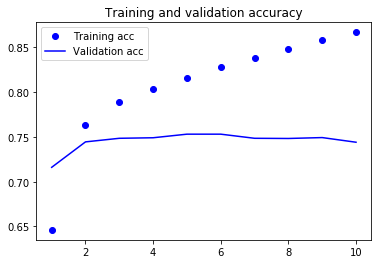

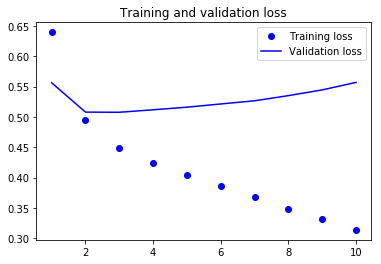

In [86]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Finally, let’s evaluate the model on the test data. First, you need to tokenize the test data.

### Tokenizing the data of the test set

In [96]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg','pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.array(labels)

### Evaluating the model on the test set

In [98]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 58us/step


[1.4959006510162354, 0.49787999999999999]

### Understanding Recurrent Neural Networks

To make these notions of loop and state clear, let’s implement the forward pass of a toy RNN in Numpy. This RNN takes as input a sequence of vectors, which you’ll encode as a 2D tensor of size (timesteps, input_features). It loops over timesteps, and at each timestep, it considers its current state at t and the input at t (of shape (input_ features,), and combines them to obtain the output at t. You’ll then set the state for the next step to be this previous output. For the first timestep, the previous output isn’t defined; hence, there is no current state. So, you’ll initialize the state as an all- zero vector called the initial state of the network.

### Pseudocode RNN

In [102]:
#state_t = 0
#for input_t in input_sequence:
#    output_t = f(input_t, state_t)
#    state_t = output_t

### Numpy Implementation of a simple RNN

In [ ]:
import numpy as np

timesteps = 100
input_features =32
output_features = 64

input = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output)t
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

### A recurrent layer in Keras
he process you just naively implemented in Numpy corresponds to an actual Keras layer—the SimpleRNN layer:

In [104]:
from keras.layers import SimpleRNN

Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D ten- sor of shape (batch_size, timesteps, output_features)) or only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). These two modes are controlled by the return_sequences constructor argument. Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep:


In [5]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence:

In [108]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________



It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return full sequence of outputs:

In [109]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now, let’s use such a model on the IMDB movie-review-classification problem. First,
preprocess the data.


### Preparing the IMDB datasets

In [10]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen =  500
batch_size = 32

print('Loading data..')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features)
print(len(input_train), 'train sequence')
print(len(input_test), 'test sequence')

print('Pad sequence (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_train = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train.shape:', input_train.shape)
print('input_test.shape:',input_test.shape)

Loading data..
25000 train sequence
25000 test sequence
Pad sequence (samples x time)
input_train.shape: (25000, 500)
input_test.shape: (25000,)


### Training the model with Embedding and Simple RNN layers

In [11]:
from keras.layers import Dense
model =  Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10,
                   batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 45s 2ms/step - loss: 0.6954 - acc: 0.5036 - val_loss: 0.6931 - val_acc: 0.5098
Epoch 2/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.6534 - acc: 0.6360 - val_loss: 0.7162 - val_acc: 0.5018
Epoch 3/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.5289 - acc: 0.7583 - val_loss: 0.8083 - val_acc: 0.4964
Epoch 4/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.3612 - acc: 0.8556 - val_loss: 0.9740 - val_acc: 0.4912
Epoch 5/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.2182 - acc: 0.9253 - val_loss: 1.1964 - val_acc: 0.4854
Epoch 6/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.1174 - acc: 0.9651 - val_loss: 1.4153 - val_acc: 0.4930
Epoch 7/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.0652 - acc: 0.9828 - val_loss: 1.5830 - val_acc:

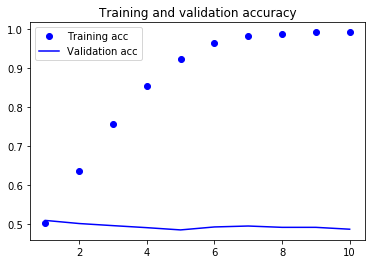

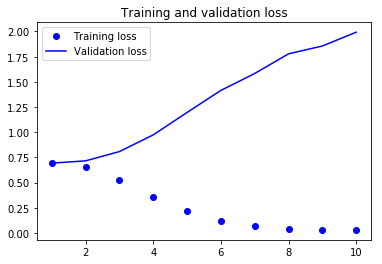

In [13]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Using the LSTM layer in Keras

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128,
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 171s 9ms/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6936 - val_acc: 0.4884
Epoch 2/10
 9728/20000 [=============>................] - ETA: 2:07 - loss: 0.6875 - acc: 0.5579

In [ ]:
# Fix: Creating a plotting Function
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)

This time, you achieve up to 89% validation accuracy. Not bad: certainly much better than the SimpleRNN network—that’s largely because LSTM suffers much less from the vanishing-gradient problem—and slightly better than the fully connected approach from chapter 3, even though you’re looking at less data than you were in chapter 3. You’re truncating sequences after 500 timesteps, whereas in chapter 3, you were con- sidering full sequences.

### Advanced use of recurrent neural networks